In [1]:
#Importing required libraries

import numpy as np
import pandas as pd
import re
re.__version__

import html
import unicodedata

import en_core_web_sm
nlp = en_core_web_sm.load()

import matplotlib
import matplotlib.pyplot as plt
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.datasets import make_classification
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

C:\Users\sathi.LAPTOP-6VSGULQ7\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\sathi.LAPTOP-6VSGULQ7\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\sathi.LAPTOP-6VSGULQ7\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\sathi.LAPTOP-6VSGULQ7\Anaconda3\lib\site-packages

In [2]:
elec_tweets = pd.read_csv('US_Elections_2020.csv')
elec_tweets.head()

,text,sentiment,negative_reason
0,"b'@robreiner so afraid of Nov, Dec, and Jan! E...",0,covid19
1,"b""RT @SueC00K: Lord Sumption launches Recovery...",0,others
2,b'RT @WalidPhares: Uber Timing: after #Biden a...,0,covid19
3,b'Every 107 seconds an American is dying from ...,1,NaN
4,b'RT @thewebbix: The #Democrats embrace #Diver...,1,NaN


In [3]:
#remove html tags and attributes
def remove_tag(text):
    tag=re.compile(r'<[^>]+>')
    return tag.sub(' ',text)
   

#replace html characters with ascii code equivalent
def html_convert(text):    
    text = html.unescape(text)
    text = unicodedata.normalize('NFKD',text).encode('ascii','ignore').decode('utf-8')
    return text

#remove URLs and convert all characters into lowercase
def url_lower(s):
    s=re.sub(r'((www\.[\S]+)|(https?://[\S]+))', ' ', s)
    s=s.lower()
    return s

#remove stopwords, and lemmatize words
with open("stop_words.txt") as f:      
     stop_word = f.read().splitlines()   
pd.DataFrame(stop_word).to_csv("stop_words.txt",index=False)    #save the text file to the directory using this code

def stopword(text):
    
    doc=nlp(text,disable=['ner','parser'])              
    lemmas = [token.lemma_ for token in doc]           
    a_lemmas=[lemma for lemma in lemmas if lemma not in stop_word and lemma !='-pron-' and lemma !='-PRON-']     
    return ' '.join(a_lemmas)

#remove some punctuations
def pun_remove(text):
    punctuations='''!()[]{};:"/\,@.+-?#$%^*_~'''    
    for char in text:
           if (char in punctuations):
                  text=text.replace(char," ")
    return text

# remove retweet
def retweet(text):
    text = re.sub(r'\brt\b', '', text)
    return text

#remove emoji
def remove_emoji(text):
    emoji = re.compile(r'\\[x][a-z\d]{2}')
    text = re.sub(emoji,'', text)
    return text

# replace multiple spaces with a single space
def space(text):    
    text = re.sub(r'\s+', ' ', text)
    return text

#remove character \\n \\n\\n and b',b" characters
def remove_b_n(text):
    text=text.replace("\\n\\n"," ")
    text=text.replace("\\n"," ")
    text=text.replace("\n"," ")
    text=text.replace("b'"," ")
    text=text.replace('b"'," ")
    return text


In [4]:
elec_tweets['text']=elec_tweets['text'].apply(remove_b_n)

In [5]:
elec_tweets['text']=elec_tweets['text'].apply(remove_tag)
elec_tweets['text']=elec_tweets['text'].apply(html_convert)
elec_tweets['text']=elec_tweets['text'].apply(url_lower)
elec_tweets['text']=elec_tweets['text'].apply(retweet)
elec_tweets['text']=elec_tweets['text'].apply(remove_emoji)

In [6]:
elec_tweets['text']=elec_tweets['text'].apply(pun_remove)

In [7]:
elec_tweets['text']=elec_tweets['text'].apply(stopword)

In [8]:
elec_tweets['text']=elec_tweets['text'].apply(space)

In [9]:
elec_tweets.head()    

,text,sentiment,negative_reason
0,robreiner afraid nov dec jan bidenharris2020 ...,0,covid19
1,suec00k lord sumption launch recovery initiat...,0,others
2,walidphare uber time biden advisor pressure b...,0,covid19
3,107 second american die trumpvirus donaldtrum...,1,NaN
4,thewebbix democrats embrace diversityandinclu...,1,NaN


In [10]:
#This csv file is used to train our classifiers
#0 is negative and 1 is positive sentiment
sentiment_og=pd.read_csv('sentiment_analysis.csv')
sentiment_og.head()

,ID,text,label
0,7.680980e+17,Josh Jenkins is looking forward to TAB Breeder...,1
1,7.680980e+17,RT @MianUsmanJaved: Congratulations Pakistan o...,1
2,7.680980e+17,"RT @PEPalerts: This September, @YESmag is taki...",1
3,7.680980e+17,"RT @david_gaibis: Newly painted walls, thanks ...",1
4,7.680980e+17,RT @CedricFeschotte: Excited to announce: as o...,1


In [11]:
sentiment= sentiment_og.groupby('label').apply(lambda x: x.sample(frac=0.2))
sentiment.tail()

ID                                               text  \
label                                                                           
1     244146  7.969360e+17  @frimmy_adu happy biryhday kwakes! https://t.c...   
      150398  7.821870e+17  Best #Hotel Deals in #Cromford #WillersleyCast...   
      367588  8.014610e+17  @SpencerOwen Don't forget to hashtag it!!! htt...   
      260884  7.975150e+17  @JanWindglows But be comforted in the knowledg...   
      15175   7.682620e+17  HAPPY BIRTHDAY to my gf Paige ❤️ glad we could...   

              label  
label                
1     244146      1  
      150398      1  
      367588      1  
      260884      1  
      15175       1

In [12]:
#shuffle data

sentiment=sentiment.sample(frac=1).reset_index(drop=True)
sentiment.head()

,ID,text,label
0,8.000980e+17,and was too scared to take it to court so he s...,0
1,8.026160e+17,Baltimore Ravens vs Miami Dolphins - 3 great L...,1
2,7.987600e+17,New Video - Long haired brunette young gay Rob...,0
3,8.043050e+17,too early for this shit https://t.co/8cy1b6i4YG,0
4,7.973260e+17,Ugandans after Beating #Congo be like ✌😂#Mujje...,0


In [13]:
#Since the define functions for cleaning can also be applied into this data set, we just apply the functions.

sentiment['text']=sentiment['text'].apply(remove_b_n)

In [14]:
sentiment['text']=sentiment['text'].apply(remove_tag)
sentiment['text']=sentiment['text'].apply(html_convert)
sentiment['text']=sentiment['text'].apply(url_lower)
sentiment['text']=sentiment['text'].apply(retweet)
sentiment['text']=sentiment['text'].apply(remove_emoji)

In [15]:
sentiment['text']=sentiment['text'].apply(pun_remove)

In [16]:
sentiment['text']=sentiment['text'].apply(stopword)

In [17]:
sentiment['text']=sentiment['text'].apply(space)

In [18]:
sentiment.head()

,ID,text,label
0,8.000980e+17,scared court settle 25mil trustworthy,0
1,8.026160e+17,baltimore raven miami dolphin 3 great ll seat ...,1
2,7.987600e+17,video long haired brunette young gay robert as...,0
3,8.043050e+17,early shit,0
4,7.973260e+17,ugandan beat congo mujjetulumbe ugandacrane ro...,0


In [19]:
#determine the political party to which the tweet is addresed to

republican=['trump','donald','borisjohnson','moscowmitch','conservative','republican','votered','redwave','4moreyears','redmirage','QANON','Cancel Culture','cancel culture']
democratic=['biden','joe','kamalaharris','democrat','voteblue','bluewave','bidenharris','blm','for the people']
text=elec_tweets['text']
elec_tweets['Party']='N'
count_both=0
count_demo=0
count_repu=0
count_others=0
for i in range(len(text)):
  if (text.str.contains('|'.join(republican))[i]==True) & (text.str.contains('|'.join(democratic))[i]==True): 
        elec_tweets['Party'][i]='Both'
        count_both+=1
  elif (text.str.contains('|'.join(republican))[i]==True) & (text.str.contains('&'.join(democratic))[i]==False):     #'Republican Party' means tweets only relevant to Republican Party
        elec_tweets['Party'][i]='Republican Party'
        count_repu+=1
  elif (text.str.contains('&'.join(republican))[i]==False) & (text.str.contains('|'.join(democratic))[i]==True):     #'Democratic Party' means tweets only relevant to Democratic Party
        elec_tweets['Party'][i]='Democratic Party'                                  
        count_demo+=1
  else:
       elec_tweets['Party'][i]='Others'
       count_others+=1
    
elec_tweets['Party']

0       Democratic Party
1                 Others
2       Democratic Party
3                   Both
4       Democratic Party
              ...       
2547              Others
2548    Democratic Party
2549    Republican Party
2550    Democratic Party
2551              Others
Name: Party, Length: 2552, dtype: object

In [20]:
#Tweets associated with Democratic Party
elec_tweets[elec_tweets['Party']=='Democratic Party']

,text,sentiment,negative_reason,Party
0,robreiner afraid nov dec jan bidenharris2020 ...,0,covid19,Democratic Party
2,walidphare uber time biden advisor pressure b...,0,covid19,Democratic Party
4,thewebbix democrats embrace diversityandinclu...,1,NaN,Democratic Party
10,breakingnew october catsoftwitter dogsoftwitt...,0,corruption,Democratic Party
15,watch happen 4 57 dethippiechick 's broadcast...,1,NaN,Democratic Party
...,...,...,...,...
2524,I trunalimunumaprzure bidenharris2020 ',1,NaN,Democratic Party
2525,azynnn tear voteblue ',0,others,Democratic Party
2531,foxnew broadcast joebiden rally st paul cnn m...,1,NaN,Democratic Party
2548,nowthisnew deliver today montgomery county pa...,1,NaN,Democratic Party


In [21]:
#Tweets associated with Republican Party
elec_tweets[elec_tweets['Party']=='Republican Party']

,text,sentiment,negative_reason,Party
5,accelerate & rise american kill trumpvirus,0,discrimination,Republican Party
6,realdonaldtrump 961 dead american day 240 tim...,0,discrimination,Republican Party
8,charliekirk11 reason realdonaldtrump 3 rally ...,0,corruption,Republican Party
11,realdonaldtrump ur campaign pay people rig me...,0,crime,Republican Party
13,realdonaldtrump maga disgusting sunday school ',0,discrimination,Republican Party
...,...,...,...,...
2528,I poll trump win landslide victory paint map ...,1,NaN,Republican Party
2534,realdonaldtrump kill american dream covid cas...,0,corruption,Republican Party
2539,trump force hold rally front small socially d...,0,discrimination,Republican Party
2540,trumpsdeadlysin unlimited covid 30 000 lie fa...,0,others,Republican Party


In [22]:
#Tweets associated with both parties
elec_tweets[elec_tweets['Party']=='Both']

,text,sentiment,negative_reason,Party
3,107 second american die trumpvirus donaldtrum...,1,NaN,Both
9,joebarri concern hunterbiden trump ass kisser...,0,covid19,Both
16,joebiden call trump supporter ugly shame day ...,0,corruption,Both
18,realdonaldtrump I will glad listen ass voice ...,0,covid19,Both
62,rwtrollpatrol joebiden watch great film meida...,1,NaN,Both
...,...,...,...,...
2494,mike pence realdonaldtrump america n't afford...,0,discrimination,Both
2502,kokomothegreat realdonaldtrump healthcare pro...,0,crime,Both
2526,biden lead trump poll exist pollster force tr...,0,discrimination,Both
2532,iaco poll wishful thinking democrat fake news...,0,corruption,Both


In [23]:
# count of different parties 

print('The number of the tweets that identify only Democratic Party is: ', count_demo)
print('The number of the tweets that identify only Republican Party is: ', count_repu)
print('The number of the tweets that identify Both Parties is: ', count_both)
print('The number of the tweets that identify others is: ', count_others)

The number of the tweets that identify only Democratic Party is:  565
The number of the tweets that identify only Republican Party is:  654
The number of the tweets that identify Both Parties is:  282
The number of the tweets that identify others is:  1051


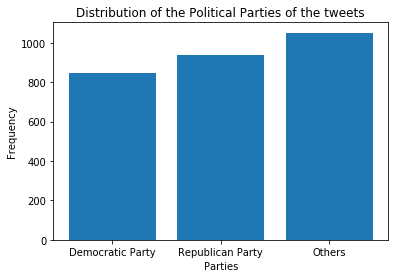

In [24]:
### frequency distribution bar plot

party=['Democratic Party','Republican Party','Others']
freq=[count_demo+count_both,count_repu+count_both,count_others]  #I added "both" to the two groups "Democratic Party" and "Republican Party" here to see the general frequency distribution
plt.bar(party, freq)
plt.title("Distribution of the Political Parties of the tweets")
plt.xlabel("Parties")
plt.ylabel("Frequency")

plt.show()

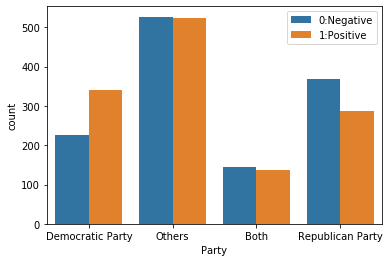

In [25]:
#Bar graph showing the negative and positive tweets addresed to each party

ax = sns.countplot(x='Party', hue='sentiment', data=elec_tweets)
legend_labels, _= ax.get_legend_handles_labels()
ax.legend(legend_labels, ['0:Negative','1:Positive'], bbox_to_anchor=(1,1))
plt.show();

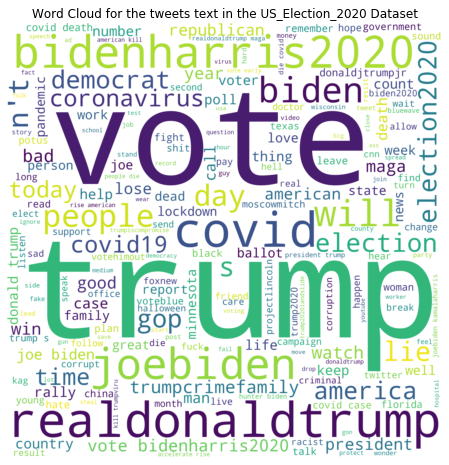

In [26]:
# wordcloud for all texts of the tweets(text cleaned already)
words=''
for val in elec_tweets['text']: 
    # typecaste each val to string 
    val = str(val) 
    # split the value 
    tokens = val.split() 
    words += " ".join(tokens)+" "
    
cloud=WordCloud(width = 2500, height = 2500,background_color='white',).generate(words)
plt.figure(figsize = (8, 8))
plt.imshow(cloud,interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for the tweets text in the US_Election_2020 Dataset')
plt.show()

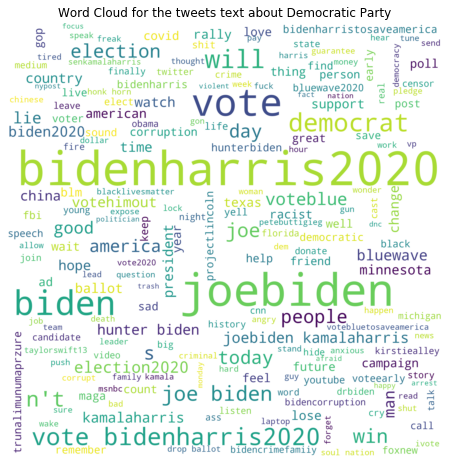

In [27]:
#wordcloud for tweets only about Democratic Party

words=''
for val in elec_tweets['text'][elec_tweets['Party']=='Democratic Party']: 
    # typecaste each val to string 
    val = str(val) 
    # split the value 
    tokens = val.split() 
    words += " ".join(tokens)+" "
    
cloud=WordCloud(width = 2500, height = 2500,background_color='white',).generate(words)
plt.figure(figsize = (8, 8))
plt.imshow(cloud,interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for the tweets text about Democratic Party')
plt.show()

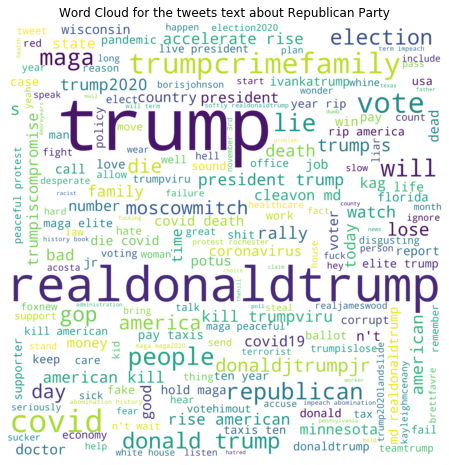

In [28]:
#wordcloud for tweets only about Republican Party

words=''
for val in elec_tweets['text'][elec_tweets['Party']=='Republican Party']: 
    # typecaste each val to string 
    val = str(val) 
    # split the value 
    tokens = val.split() 
    words += " ".join(tokens)+" "
    
cloud=WordCloud(width = 2500, height = 2500,background_color='white',).generate(words)
plt.figure(figsize = (8, 8))
plt.imshow(cloud,interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for the tweets text about Republican Party')
plt.show()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001A86614AFD0>],
      dtype=object)

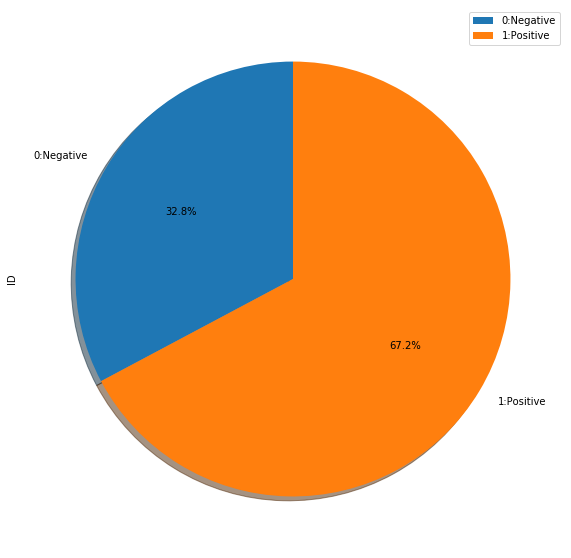

In [29]:
#Pie chart showing the distribution of positve and negative tweets

labels='0:Negative','1:Positive'
sentiment.groupby(['label']).sum().plot(kind='pie', subplots=True, labels=labels,shadow = True,startangle=90,figsize=(15,10), autopct='%1.1f%%')

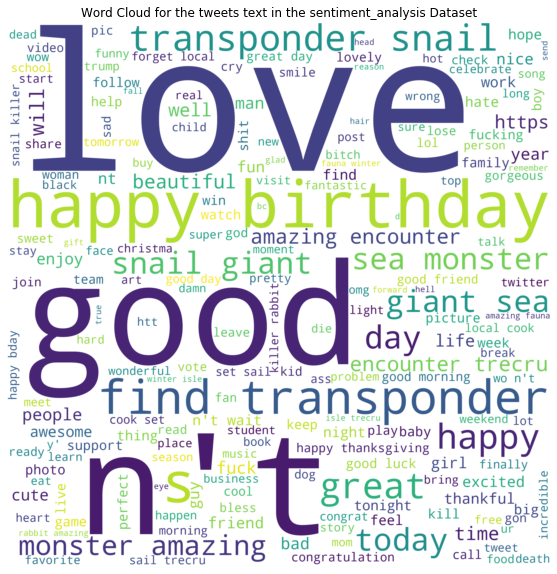

In [30]:
#Wordcloud for tweets text in sentiment_analysis Dataset

words=''
for val in sentiment['text']: 
    # typecaste each val to string 
    val = str(val) 
    # split the value 
    tokens = val.split() 
    words += " ".join(tokens)+" "
    
cloud=WordCloud(width = 2500, height = 2500,background_color='white',).generate(words)
plt.figure(figsize = (10, 10))
plt.imshow(cloud,interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for the tweets text in the sentiment_analysis Dataset')
plt.show()

## BoW and TF-IDF Vectors

In [31]:
#Generating BoW vectors

vector1=CountVectorizer(max_features=5000,token_pattern=r'\w+').fit(sentiment.text)
vector_bow=vector1.transform(sentiment.text)
vector_bow

<110078x5000 sparse matrix of type '<class 'numpy.int64'>'
	with 569968 stored elements in Compressed Sparse Row format>

In [32]:
#Generating TF-IDF vectors

vector2=TfidfVectorizer(max_features=5000,token_pattern=r'\w+').fit(sentiment.text)
vector_tfidf=vector2.transform(sentiment.text)
vector_tfidf

<110078x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 569968 stored elements in Compressed Sparse Row format>

In [33]:
y1=sentiment.label
X1=vector_bow
X_train1,X_test1,y_train1,y_test1=train_test_split(X1,y1,test_size=0.3,random_state=0,stratify=sentiment['label'])

In [34]:
y2=sentiment.label
X2=vector_tfidf
X_train2,X_test2,y_train2,y_test2=train_test_split(X2,y2,test_size=0.3,random_state=0,stratify=sentiment['label'])

### Classifiers for BoW vector

In [35]:
#Training the KNN model and testing the model for BoW vectors

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train1, y_train1)
y_pred2_train=knn.predict(X_train1)
y_pred2_test=knn.predict(X_test1)
print('Training accuracy for k-NN is:{}%'.format(round(accuracy_score(y_train1,y_pred2_train)*100,2)))
print('Test accuracy for k-NN is: {}%'.format(round(accuracy_score(y_test1,y_pred2_test)*100,2)))

Training accuracy for k-NN is:91.9%
Test accuracy for k-NN is: 87.82%


In [36]:
#Training the Naive Bayes model and testing the model for BoW vectors

mnb = MultinomialNB()
mnb.fit(X_train1,y_train1)
y_pred3_train=mnb.predict(X_train1)
y_pred3_test=mnb.predict(X_test1)
print('Training accuracy for Naive Bayes is:{}%'.format(round(accuracy_score(y_train1,y_pred3_train)*100,2)))
print('Test accuracy for Naive Bayes is: {}%'.format(round(accuracy_score(y_test1,y_pred3_test)*100,2)))

Training accuracy for Naive Bayes is:93.69%
Test accuracy for Naive Bayes is: 93.08%


In [37]:
#Training the Logistic Regression model and testing the model for BoW vectors

from sklearn.linear_model import LogisticRegression

log_reg=LogisticRegression(solver='liblinear')
log_reg.fit(X_train1,y_train1)
y_pred1_train=log_reg.predict(X_train1)
y_pred1_test=log_reg.predict(X_test1)
print('Training accuracy for logistic regression is:{}%'.format(round(accuracy_score(y_train1,y_pred1_train)*100,2)))
print('Test accuracy for logistic regression is: {}%'.format(round(accuracy_score(y_test1,y_pred1_test)*100,2)))

Training accuracy for logistic regression is:96.02%
Test accuracy for logistic regression is: 94.57%


In [38]:
#Training the SVM model and testing the model for BoW vectors

from sklearn import svm

svm_=svm.SVC(kernel='linear')
svm_.fit(X_train1,y_train1)
y_pred4_train=svm_.predict(X_train1)
y_pred4_test=svm_.predict(X_test1)
print('Training accuracy for SVM is:{}%'.format(round(accuracy_score(y_train1,y_pred4_train)*100,2)))
print('Test accuracy for SVM is: {}%'.format(round(accuracy_score(y_test1,y_pred4_test)*100,2)))

Training accuracy for SVM is:96.38%
Test accuracy for SVM is: 94.38%


### Classifiers for TF-IDF vector

In [39]:
#Training the KNN model and testing the model for TF-IDF vectors

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train2, y_train2)
y_pred2_train_=knn.predict(X_train2)
y_pred2_test_=knn.predict(X_test2)
print('Training accuracy for k-NN is:{}%'.format(round(accuracy_score(y_train2,y_pred2_train_)*100,2)))
print('Test accuracy for k-NN is: {}%'.format(round(accuracy_score(y_test2,y_pred2_test_)*100,2)))

Training accuracy for k-NN is:86.21%
Test accuracy for k-NN is: 78.01%


In [40]:
#Training the Naive Bayes model and testing the model for TF-IDF vectors

mnb = MultinomialNB()
mnb.fit(X_train2,y_train2)
y_pred3_train_=mnb.predict(X_train2)
y_pred3_test_=mnb.predict(X_test2)
print('Training accuracy for Naive Bayes is:{}%'.format(round(accuracy_score(y_train2,y_pred3_train_)*100,2)))
print('Test accuracy for Naive Bayes is: {}%'.format(round(accuracy_score(y_test2,y_pred3_test_)*100,2)))

Training accuracy for Naive Bayes is:92.75%
Test accuracy for Naive Bayes is: 92.04%


In [41]:
#Training the Logistic Regression model and testing the model for TF-IDF vectors

log_reg=LogisticRegression(solver='liblinear').fit(X_train2,y_train2)
y_pred1_train_=log_reg.predict(X_train2)
y_pred1_test_=log_reg.predict(X_test2)
print('Training accuracy for logistic regression is:{}%'.format(round(accuracy_score(y_train2,y_pred1_train_)*100,2)))
print('Test accuracy for logistic regression is: {}%'.format(round(accuracy_score(y_test2,y_pred1_test_)*100,2)))

Training accuracy for logistic regression is:95.56%
Test accuracy for logistic regression is: 94.51%


In [42]:
#Training the SVM model and testing the model for TF-IDF vectors

svm_=svm.SVC(kernel='linear')
svm_.fit(X_train2,y_train2)
y_pred4_train_=svm_.predict(X_train2)
y_pred4_test_=svm_.predict(X_test2)
print('Training accuracy for SVM is:{}%'.format(round(accuracy_score(y_train2,y_pred4_train_)*100,2)))
print('Test accuracy for SVM is: {}%'.format(round(accuracy_score(y_test2,y_pred4_test_)*100,2)))

Training accuracy for SVM is:95.88%
Test accuracy for SVM is: 94.57%


## Evaluating the classifier on the US Election dataset

In [43]:
#CountVectorize sentiment in the tweets

vect=CountVectorizer(max_features=5000,token_pattern=r'\w+').fit(elec_tweets.text)
vect_=vect.transform(elec_tweets.text)

#using the MNB model above to evaluate the US Election Dataset

y=elec_tweets.sentiment
X=vect_
mnb=MultinomialNB().fit(X,y)
y_predicted=mnb.predict(X)

print('Accuracy using a Multinomial Naive Bayes Classifier on 2020 US election data is: {}%'.format(round(accuracy_score(y,y_predicted)*100,2)))

Accuracy using a Multinomial Naive Bayes Classifier on 2020 US election data is: 94.32%


In [44]:
#CountVectorize sentiment in the tweets

vect=CountVectorizer(max_features=5000,token_pattern=r'\w+').fit(elec_tweets.text)
vect_=vect.transform(elec_tweets.text)

#using the Logistic Regression model above to evaluate the US Election Dataset

y=elec_tweets.sentiment
X=vect_
log_reg=LogisticRegression(solver='liblinear').fit(X,y)
y_predicted=log_reg.predict(X)

print('Accuracy using a Logistic Regression Classifier on 2020 US election data is: {}%'.format(round(accuracy_score(y,y_predicted)*100,2)))

Accuracy using a Logistic Regression Classifier on 2020 US election data is: 98.04%


## Visualizing on the Obtained Results

In [45]:
#Adding Prediction column to the dataframe

elec_tweets['Prediction']=y_predicted
elec_tweets

,text,sentiment,negative_reason,Party,Prediction
0,robreiner afraid nov dec jan bidenharris2020 ...,0,covid19,Democratic Party,0
1,suec00k lord sumption launch recovery initiat...,0,others,Others,0
2,walidphare uber time biden advisor pressure b...,0,covid19,Democratic Party,0
3,107 second american die trumpvirus donaldtrum...,1,NaN,Both,1
4,thewebbix democrats embrace diversityandinclu...,1,NaN,Democratic Party,1
...,...,...,...,...,...
2547,boycottutah friday october 30 2020 citizen I ...,1,NaN,Others,1
2548,nowthisnew deliver today montgomery county pa...,1,NaN,Democratic Party,1
2549,donaldjtrumpjr duhnnie jr lie fox number covi...,0,covid19,Republican Party,0
2550,pale ranger idea joebiden waste time minnesot...,0,covid19,Democratic Party,0


In [46]:
#Accuracy of prediction wrt Republicans

import seaborn as sns
from sklearn.metrics import confusion_matrix

tweet_rep = elec_tweets[elec_tweets['Party']=='Republican Party']
acc_rep = accuracy_score(tweet_rep['sentiment'],tweet_rep['Prediction'])
print("Accuracy of Republican Party is: {}%".format(round(acc_rep*100,2)))

Accuracy of Republican Party is: 97.71%


In [47]:
#Confusion matrix for Republicans

print(confusion_matrix(tweet_rep['sentiment'],tweet_rep['Prediction']))

[[365   3]
 [ 12 274]]


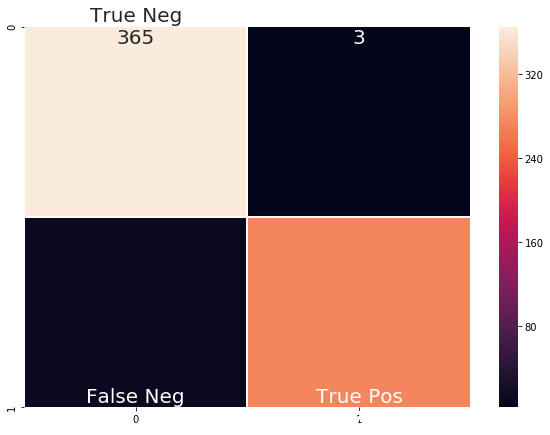

In [48]:
#confusion matrix visualization

cm_rep = confusion_matrix(tweet_rep['sentiment'],tweet_rep['Prediction'])
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cm_rep.flatten()]
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)
plt.figure(figsize=(10,7))
sns.heatmap(cm_rep,annot=labels,linewidths=1,fmt='',annot_kws={"size":20})
plt.show()


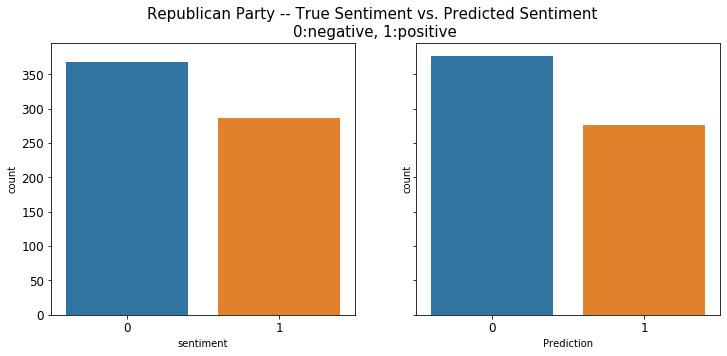

In [49]:
#True vs Predicted sentiment using a histogram visualization (Republicans)

fig, (ax1, ax2) = plt.subplots(1,2,sharey=True, figsize=(12,5))
fig.suptitle('Republican Party -- True Sentiment vs. Predicted Sentiment \n0:negative, 1:positive',fontsize=15)
sns.countplot(x='sentiment', data=tweet_rep,ax=ax1).tick_params(labelsize=12)
sns.countplot(x='Prediction', data=tweet_rep,ax=ax2).tick_params(labelsize=12)

In [51]:
#Accuracy of prediction wrt Democrats

tweet_demo = elec_tweets[elec_tweets['Party']=='Democratic Party']
acc_demo = accuracy_score(tweet_demo['sentiment'],tweet_demo['Prediction'])
print("Accuracy of Democratic Party is: {}%".format(round(acc_demo*100,2)))

Accuracy of Democratic Party is: 98.05%


In [52]:
#Confusion matrix for Democrats

print(confusion_matrix(tweet_demo['sentiment'],tweet_demo['Prediction']))

[[217   8]
 [  3 337]]


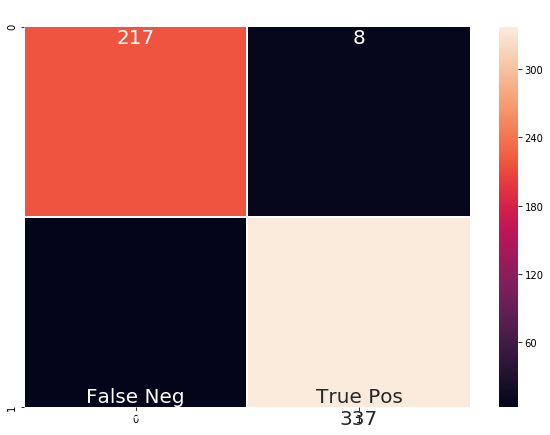

In [53]:
#confusion matrix visualization

cm_demo = confusion_matrix(tweet_demo['sentiment'],tweet_demo['Prediction'])
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cm_demo.flatten()]
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)
plt.figure(figsize=(10,7))
sns.heatmap(cm_demo,annot=labels,linewidths=1,fmt='',annot_kws={"size":20})

plt.show()

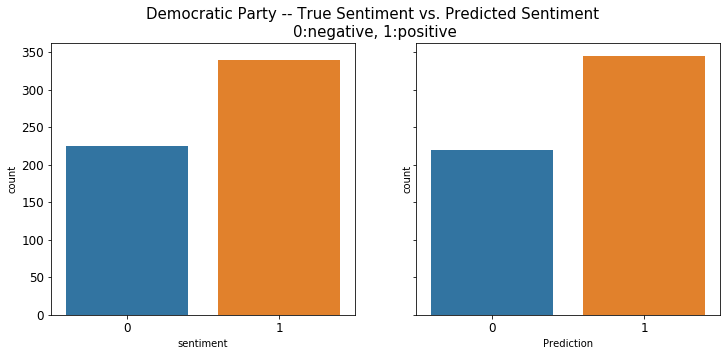

In [54]:
#True vs Predicted sentiment using a histogram visualization (Democrats)

fig, (ax1, ax2) = plt.subplots(1,2,sharey=True, figsize=(12,5))
fig.suptitle('Democratic Party -- True Sentiment vs. Predicted Sentiment \n0:negative, 1:positive',fontsize=15)
sns.countplot(x='sentiment', data=tweet_demo,ax=ax1).tick_params(labelsize=12)
sns.countplot(x='Prediction', data=tweet_demo,ax=ax2).tick_params(labelsize=12)

## Negative Reasons

In [55]:
#Grabbing the tweets labeled with 0 (negative polarity)

negative_tweet=elec_tweets[elec_tweets['sentiment']==0]
negative_tweet

,text,sentiment,negative_reason,Party,Prediction
0,robreiner afraid nov dec jan bidenharris2020 ...,0,covid19,Democratic Party,0
1,suec00k lord sumption launch recovery initiat...,0,others,Others,0
2,walidphare uber time biden advisor pressure b...,0,covid19,Democratic Party,0
5,accelerate & rise american kill trumpvirus,0,discrimination,Republican Party,0
6,realdonaldtrump 961 dead american day 240 tim...,0,discrimination,Republican Party,0
...,...,...,...,...,...
2542,love air watch watch news hate brainwashing r...,0,crime,Others,0
2543,euinaus challenge humanity year covid 19 faul...,0,discrimination,Others,0
2544,ty flip dump day 4 year 4 day resist maga cov...,0,covid19,Others,1
2549,donaldjtrumpjr duhnnie jr lie fox number covi...,0,covid19,Republican Party,0


In [57]:
#BoW model and splitting into training and testing sets

negative_tweet=elec_tweets[elec_tweets['sentiment']==0]
vect=CountVectorizer(max_features=5000,token_pattern=r'\w+').fit(negative_tweet.text)
vect_=vect.transform(negative_tweet.text)

#split into training data and test data
Xn=vect_
yn=negative_tweet.negative_reason
Xn_train,Xn_test,yn_train,yn_test=train_test_split(Xn,yn,test_size=0.3,random_state=12345,stratify=negative_tweet['negative_reason'])

In [59]:
#Cross-validation and Grid Search

from sklearn.model_selection import GridSearchCV

parameters1 = {'C':[ 0.1, 1, 10, 100], 'solver':('liblinear','lbfgs', 'newton-cg')}

cvg_lr = LogisticRegression()
cvg1 = GridSearchCV(cvg_lr, parameters1, cv=10, n_jobs=-1)
cvg1.fit(Xn_train, yn_train)

print('The best cross-validation score: {}%'.format(round(cvg1.best_score_*100,2)))
print('The best parameter:\n', cvg1.best_params_)

The best cross-validation score: 33.6%
The best parameter:
 {'C': 0.1, 'solver': 'liblinear'}


In [60]:
#Training with Logistic Regression model and feeding the model for prediction

cvg_lr=LogisticRegression(C=0.1,solver='liblinear').fit(Xn_train,yn_train)
train_pred1=cvg_lr.predict(Xn_train)
test_pred1=cvg_lr.predict(Xn_test)
print('Training accuracy for Logistic Regression is:{}%'.format(round(accuracy_score(yn_train,train_pred1)*100,2)))
print('Test accuracy for Logistic Regression is: {}%'.format(round(accuracy_score(yn_test,test_pred1)*100,2)))

Training accuracy for Logistic Regression is:66.06%
Test accuracy for Logistic Regression is: 35.53%


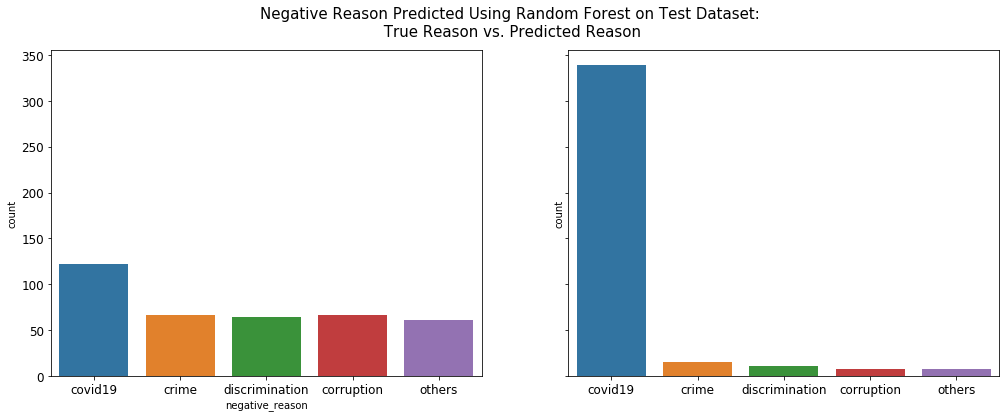

In [62]:
#Obtained results visualized

fig, (ax1, ax2) = plt.subplots(1,2,sharey=True, figsize=(17,6))
fig.suptitle('Negative Reason Predicted Using Logistic Regression on Test Dataset:\n True Reason vs. Predicted Reason',fontsize=15)
sns.countplot(x=yn_test,ax=ax1,order=['covid19','crime','discrimination','corruption','others']).tick_params(labelsize=12)
sns.countplot(x=test_pred1, ax=ax2,order=['covid19','crime','discrimination','corruption','others']).tick_params(labelsize=12)

In [68]:
unique, counts = np.unique(test_pred1, return_counts=True)
dict(zip(unique, counts))

{'corruption': 7,
 'covid19': 339,
 'crime': 15,
 'discrimination': 11,
 'others': 8}

In [69]:
unique, counts = np.unique(yn_test, return_counts=True)
dict(zip(unique, counts))

{'corruption': 66,
 'covid19': 122,
 'crime': 67,
 'discrimination': 64,
 'others': 61}